In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, Reshape, Concatenate, BatchNormalization, LayerNormalization, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
import os

In [2]:
context_window=(26,26)
batch_size=32

In [3]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\Train\Images",
    color_mode='rgb',
    image_size=context_window,
    batch_size=128,
    shuffle=False,
)

Found 18001 files belonging to 9 classes.


In [4]:
test_dataset=tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\IDS_IPS Softmax Classification\Datasets\Final Datasets\Test\Images",
    color_mode='rgb',
    image_size=context_window,
    batch_size=128,
    shuffle=False,
)

Found 4493 files belonging to 9 classes.


In [2]:
def CNN_model():
    initializers=tf.keras.initializers.RandomNormal(seed=1)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(26,26,3)),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(16,kernel_size=(1,3),strides=(1,1),padding="same",kernel_initializer=initializers),
    ])

    return model

In [3]:
def LSTM_model(input_shape=(26,26,3),n_a=512, n_values=9, context_window=26):
    initializers = tf.keras.initializers.RandomNormal(seed=1)

    reshaper = Reshape((1,input_shape[1]*input_shape[2]))
    LSTMcell = LSTM(n_a, return_state=True, kernel_initializer=initializers)
    Densor1 = Dense(n_a/2, kernel_initializer=initializers, activation="relu")
    Densor2 = Dense(n_a/4,kernel_initializer=initializers,activation="relu")
    concat = Concatenate(axis=-1)
    Densor_softmax = Dense(n_values, kernel_initializer=initializers, activation='linear')
    inputs = Input(shape=input_shape)
    outputs = []
    for i in range(context_window):
        x = inputs[:, i, :, :]
        x = reshaper(x)
        if i==0:
            _, a, c = LSTMcell(x)
        else:
            _, a, c = LSTMcell(x,initial_state=[a,c])
        out = Densor1(a)
        out = Densor2(out)
        outputs.append(out)
    outputs = concat(outputs)
    outputs = Densor_softmax(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [4]:
def CNN_LSTM_model():
    input = Input(shape=(26,26,3))
    x = CNN_model()(input)
    output = LSTM_model((26,26,16),512,9,26)(x)
    
    model = Model(inputs=[input],outputs=[output])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    return model

In [5]:
model = CNN_LSTM_model()

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 26, 26, 16)        1728      
                                                                 
 model (Functional)          (None, 9)                 2096777   
                                                                 
Total params: 2,098,505
Trainable params: 2,098,505
Non-trainable params: 0
_________________________________________________________________


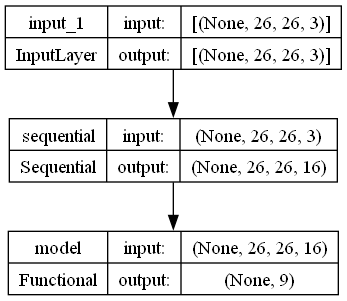

In [7]:
tf.keras.utils.plot_model(model,to_file="Softmax_LSTM_CNN_model.png",show_shapes=True)

In [27]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.prev_loss=0
    def on_epoch_end(self,epoch,logs={}):
        model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM models/model_{epoch}.h5")
        if(epoch>0 and logs.get('loss')>=self.prev_loss):
            print('\nLearning rate updated')
            self.model.optimizer.lr.assign(self.model.optimizer.lr.read_value()*0.1)
        self.prev_loss=logs.get('loss')

callbacks=myCallback()

In [28]:
history=model.fit(train_dataset,validation_data=test_dataset,batch_size=128,epochs=30,callbacks=[callbacks])

Epoch 1/30


141/141 [==============================] - 103s 292ms/step - loss: 1.0444 - accuracy: 0.7648 - val_loss: 2.0864 - val_accuracy: 0.1696
Epoch 2/30
141/141 [==============================] - 24s 171ms/step - loss: 0.7227 - accuracy: 0.7931 - val_loss: 1.5332 - val_accuracy: 0.3933
Epoch 3/30
141/141 [==============================] - 24s 169ms/step - loss: 0.6384 - accuracy: 0.8079 - val_loss: 1.1074 - val_accuracy: 0.5965
Epoch 4/30
141/141 [==============================] - 24s 172ms/step - loss: 0.5555 - accuracy: 0.8165 - val_loss: 0.6828 - val_accuracy: 0.7650
Epoch 5/30
141/141 [==============================] - 24s 169ms/step - loss: 0.3985 - accuracy: 0.8611 - val_loss: 0.4578 - val_accuracy: 0.8400
Epoch 6/30
141/141 [==============================] - 25s 179ms/step - loss: 0.3119 - accuracy: 0.8958 - val_loss: 0.3617 - val_accuracy: 0.8511
Epoch 7/30
141/141 [==============================] - 27s 193ms/step - loss: 0.2014 - accuracy: 0.9291 - val_loss: 0.2046 - val_accuracy: 0.

In [29]:
# Emergency Save
model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM models/model_{30}.h5")

In [30]:
import json

with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM.txt","w") as file:
    file.write(json.dumps(history.params))
with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM_history.txt","w") as file:
    file.write(json.dumps(history.history))

In [5]:
model=tf.keras.models.load_model(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/IDS_IPS Softmax Classification/Results/CNN_LSTM models/model_{29}.h5")

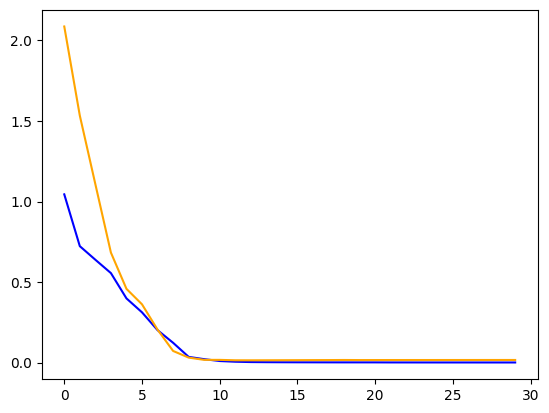

In [32]:
plt.plot(range(30),history.history["loss"],color="blue",label="Train Loss")
plt.plot(range(30),history.history["val_loss"],color="orange",label="Validation Loss")
plt.show()

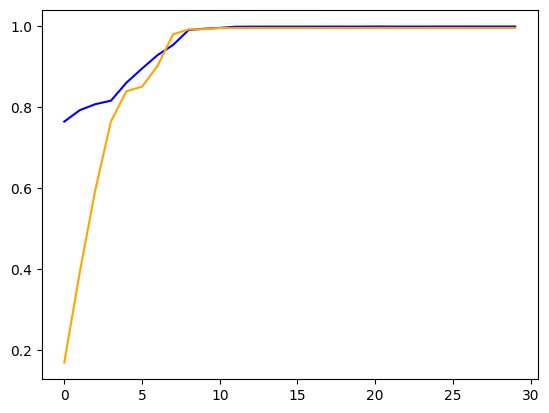

In [33]:
plt.plot(range(30),history.history["accuracy"],color="blue",label="Train Accuracy")
plt.plot(range(30),history.history["val_accuracy"],color="orange",label="Validation Accuracy")
plt.show()

In [6]:
model.evaluate(train_dataset)
model.evaluate(test_dataset)

36/36 [==============================] - 3s 75ms/step - loss: 0.0163 - accuracy: 0.9962


[0.01628781482577324, 0.996216356754303]

In [7]:
Y_test=np.concatenate([y for x,y in test_dataset],axis=0)

In [8]:
y_predict=np.argmax(tf.nn.softmax(model.predict(test_dataset)),axis=1)

36/36 [==============================] - 17s 69ms/step


In [9]:
confusion_matrix=tf.math.confusion_matrix(Y_test,y_predict)
confusion_matrix

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[3073,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  383,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,  384,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,   59,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,   45,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   30,   14,    0,    0],
       [   0,    0,    0,    0,    0,    0,   41,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  384,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,   77]])>

In [10]:
from mlxtend.plotting import plot_confusion_matrix

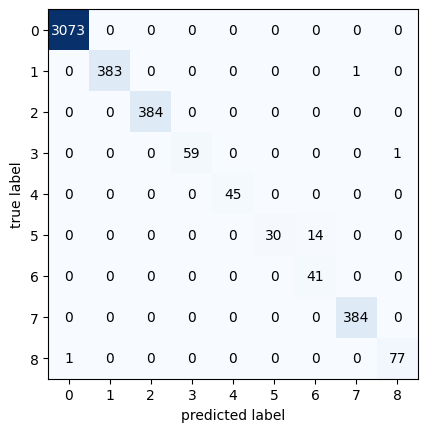

In [11]:
fig,ax=plot_confusion_matrix(confusion_matrix.numpy())
plt.show()